In [253]:
"""%pip install mne --quiet
%pip install edfio --quiet
%pip install pymatreader --quiet
%pip install git+https://github.com/lina-usc/eog-learn.git --quiet --no-deps
%pip install mne-icalabel --quiet""";

Before running this analysis, the `run_eog_lstm_regression_mp.py` and `run_eog_lstm_ica_mp.py` scripts need to have been run so that the raw files are created on the disk locally.

In [1]:
import mne
from mne.io import BaseRaw
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
def get_epochs(raw, events, baseline=(None, 0)):
  # this applies a baseline to the eyegaze channels which we dont generally want but okay for now i think
  return mne.Epochs(raw, events, tmin=-.2, tmax=1, preload=True, baseline=baseline, verbose=False)

def get_evoked(inst, picks, events=None, event_ids=("2", "5", "15"), baseline=(None, 0)):
  # see https://eoglearn.readthedocs.io/en/latest/auto_examples/plot_eegeyenet.html#sphx-glr-auto-examples-plot-eegeyenet-py
  # for stimuli locations
  if isinstance(inst, BaseRaw):
    assert events is not None, "Must pass in an events array to get evoked from Raw."
    inst = get_epochs(inst, events, baseline=baseline)
  if event_ids is None:
    return {kind: inst[kind].average().pick(picks) for kind in inst.event_id}
  return inst[event_ids].average().pick(picks)

#frontal = ["E19", "E11", "E4", "E12", "E5"]
#frontal = ["E19", "E11", "E4", "E12", "E5", "E24", "E124"]
#frontal = ["E8", "E9", "E15", "E22", "E25", "E1", "E2", "E3", "E10", "E16", "E18", "E23", "E26"]

In [3]:
def get_insts(fname_clean, event_ids=None):
    fname = Path(str(fname_clean).replace("clean", "ica"))
    if not fname.exists():
        return None

    evoked = {}
    raw = {}
    
    for kind in ["original", "clean", "noise", "ica"]:
        fname = Path(str(fname_clean).replace("clean", kind))
        raw[kind] = mne.io.read_raw_edf(fname, verbose=False)

        # Going through annotations because it is more robust than 
        # events (i.e., events are not transferable between raw objects
        # if these objects are not resampled at the same frequency). Resampling
        # of these different raw objects is done by different pieces of code.
        if kind == "original":
            annotations  = raw["original"].copy().drop_channels(['L-GAZE-X', 'L-GAZE-Y', 'L-AREA']).annotations

        raw[kind].set_annotations(annotations)
        events, _ = mne.events_from_annotations(raw[kind], regexp="^[0-9]*$", verbose=False)
        if kind == "original":        
            mapping = {"L-GAZE-X": ('eyegaze', 'px', 'left', 'x'),
                    "L-GAZE-Y": ("eyegaze", "px", "left", "y"),
                    "L-AREA": ("pupil", "au", "left")}
            mne.preprocessing.eyetracking.set_channel_types_eyetrack(raw["original"], mapping)

        if "TIME" in raw[kind].ch_names:
            raw[kind].drop_channels(["TIME"])

        ch_names = [ch_name for ch_name in raw[kind].ch_names if ch_name[0] == "E"]
        raw[kind].set_channel_types(dict(zip(ch_names, 
                                    ["eeg"]*len(ch_names))))

        evoked[kind] = get_evoked(raw[kind], "eeg", events, event_ids)    

    return raw, evoked


def get_evoked_eye(fname_clean, event_ids=None):
    fname = Path(str(fname_clean).replace("clean", "original"))
    if not fname.exists():
        return None

    raw = mne.io.read_raw_edf(fname, verbose=False)
    annotations  = raw.copy().drop_channels(['L-GAZE-X', 'L-GAZE-Y', 'L-AREA']).annotations

    raw.set_annotations(annotations)
    events, _ = mne.events_from_annotations(raw, regexp="^[0-9]*$", verbose=False)
    mapping = {"L-GAZE-X": ('eyegaze', 'px', 'left', 'x'),
            "L-GAZE-Y": ("eyegaze", "px", "left", "y"),
            "L-AREA": ("pupil", "au", "left")}
    mne.preprocessing.eyetracking.set_channel_types_eyetrack(raw, mapping)
    return get_evoked(raw, "eyegaze", events, event_ids, baseline=None)  


In [4]:
def rms(x):
  return np.sqrt(np.mean(x**2, axis=1))

def get_snrs(evoked_eye, evoked, event_id):
    ev_eye = evoked_eye[event_id].get_data()
    r = np.sqrt(ev_eye[0]**2 + ev_eye[1]**2)
    times = evoked["original"][event_id].times
    rt = times[(r > 0.05*r.max()) & (times > 0.1)][0]

    ev = {kind: evoked[kind][event_id].get_data() for kind in evoked}
    rt_masks = {"pre": evoked["original"][event_id].times < rt,
                "post": evoked["original"][event_id].times > rt}
    
    dfs = []
    dfs_topo = {("pre", "ica"): [], 
                ("pre", "clean"): [],
                ("post", "ica"): [], 
                ("post", "clean"): []}
    eeg_names = evoked["clean"][event_id].ch_names
    for condition, mask in rt_masks.items():
        signal = rms(ev["original"][:, mask])
        
        for kind in ["clean", "ica"]:
            noise = rms((ev["original"] - ev[kind])[:, mask])
            df = pd.DataFrame([10*np.log10(signal/noise)], columns=eeg_names)
            df["approach"] = kind
            df["condition"] = condition
            df["event_id"] = event_id
            dfs.append(df)

            nsr = rms(ev[kind][:, mask]) / rms(ev["original"][:, mask])
            percent_noise = 1 - nsr
            percent_noise *= 100

            data_dict = dict(list(zip(eeg_names, percent_noise)))
            df = pd.DataFrame([data_dict])
            df["event_id"] = event_id
            dfs_topo[(condition, kind)].append(df)

    return pd.concat(dfs), rt, {key: pd.concat(dfs_topo[key]) for key in dfs_topo}


In [9]:
def compute_et_xarrays():
    snr_dfs = []
    et_signals_dfs = []
    topo_ev_dfs = {("pre", "ica"): [], 
                    ("pre", "clean"): [],
                    ("post", "ica"): [], 
                    ("post", "clean"): []}    

    for fname_clean in tqdm(list(Path("processed").glob("*_clean.edf"))):
        evoked_eye = get_evoked_eye(fname_clean, event_ids=None)
        if evoked_eye is None:
            continue
        evoked  = get_insts(fname_clean)[1]

        for event_id in evoked_eye:
            # SNR analysis
            df, rt, topo_ev = get_snrs(evoked_eye, evoked, event_id)
            df["subject"], df["run"] = fname_clean.name.split("_")[:2]
            df["rt"] = rt
            snr_dfs.append(df)

            for key in topo_ev_dfs:
                topo_ev[key]["subject"], topo_ev[key]["run"] = fname_clean.name.split("_")[:2]
                topo_ev_dfs[key].append(topo_ev[key])

            # et signals
            ev_eye = evoked_eye[event_id].get_data()
            df = pd.DataFrame({
                'times': evoked_eye[event_id].times,
                'eye-x': ev_eye[0],
                'eye-y': ev_eye[1]
            })
            df = df.melt(id_vars="times", value_name="amp", var_name="ch_name")
            df["subject"], df["run"] = fname_clean.name.split("_")[:2]
            df["event_id"] = event_id
            et_signals_dfs.append(df)


    snr_df = pd.concat(snr_dfs)
    topo_ev_df = {key: pd.concat(topo_ev_dfs[key]) for key in topo_ev_dfs}


    snr_xr = snr_df.melt(id_vars=["approach", "condition", "event_id", "subject", "run", "rt"],
                         var_name="ch_name", value_name="snr")\
                   .set_index(["approach", "condition", "event_id", "subject", "run", "ch_name"]).to_xarray()
    snr_xr.to_netcdf("snr.netcdf")
    
    for condition, kind in  topo_ev_df:
        topo_ev_df[(condition, kind)]["condition"] = condition
        topo_ev_df[(condition, kind)]["kind"] = kind
    
    topo_ev_xr = pd.concat(topo_ev_df.values()).melt(id_vars=["subject", "run", "kind", "event_id", "condition"], 
                                                     var_name="ch_name", value_name="percent")\
                   .set_index(["subject", "run", "ch_name", "kind", "event_id", "condition"]).to_xarray()
    topo_ev_xr.to_netcdf("topo_erp.netcdf")

    et_signals_df = pd.concat(et_signals_dfs)
    et_signals_xr = et_signals_df.set_index(["times", "ch_name", "subject", "run", "event_id"]).to_xarray()
    et_signals_xr.to_netcdf("et_signals.netcdf")

    return snr_xr, topo_ev_xr, et_signals_xr

snr_xr, topo_ev_xr, et_signals_xr = compute_et_xarrays()

  0%|          | 0/176 [00:00<?, ?it/s]

/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_28891/1372605738.py:20: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw[kind].set_annotations(annotations)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_28891/1372605738.py:20: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw[kind].set_annotations(annotations)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_28891/1372605738.py:20: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw[kind].set_annotations(annotations)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_28891/1372605738.py:20: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw[kind].set_annotations(annotations)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_28891/1372605738.py:20: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw[kind].set_annotations(annotations)
/var/folders/3k/220tdhsn33709g

In [35]:
def compute_erp_xarrays():
    eeg_signals_dfs = []
    topo_dfs = {"clean": [], "ica": []}

    for fname_clean in tqdm(list(Path("processed").glob("*_clean.edf"))):
        insts = get_insts(fname_clean)
        if insts is None:
            continue
        raw, evoked = insts

        # TOPOMAP analysis
        eeg_names = raw["original"].copy().pick("eeg").ch_names

        nsample = min(len(raw["original"].times), len(raw["ica"])) 
        # Could probably removed once data are recomputed.
        signal = np.sqrt(np.mean(raw["original"].get_data(picks=eeg_names)[:, :nsample]**2, axis=1))

        for kind in topo_dfs:
            noise = raw["original"].get_data(picks=eeg_names)[:, :nsample] - raw[kind].get_data(picks=eeg_names)[:, :nsample]
            noise = np.sqrt(np.mean(noise**2, axis=1)) 
        
            nsr = noise / signal
            percent_noise = nsr
            percent_noise *= 100

            data_dict = dict(list(zip(eeg_names, percent_noise)))
            df = pd.DataFrame([data_dict])
            df["subject"], df["run"] = fname_clean.name.split("_")[:2]
            topo_dfs[kind].append(df)


        for event_id in evoked["original"]:
            # ERP analysis
            # eeg
            for key, kind in zip(['original', 'clean', 'ica'], ['original', 'clean-et', 'clean-ica']):
                sigs = evoked[key][event_id].get_data()
                ch_names = evoked[key][event_id].ch_names
                for ch_name, sig in zip(ch_names, sigs):
                    df = pd.DataFrame({
                        'times': evoked[key][event_id].times,
                        "amp": sig
                    })
                    df["subject"], df["run"] = fname_clean.name.split("_")[:2]
                    df["kind"] = kind
                    df["event_id"] = event_id
                    df["ch_name"] = ch_name
                    eeg_signals_dfs.append(df)

    eeg_signals_df = pd.concat(eeg_signals_dfs)
    topo_df = {kind: pd.concat(topo_dfs[kind]) for kind in topo_dfs}

    eeg_signals_xr = eeg_signals_df.set_index(["times", "kind", "event_id", "ch_name", "subject", "run"]).to_xarray()
    eeg_signals_xr.to_netcdf("eeg_signals.netcdf")

    topo_df["clean"]["kind"] = "clean"
    topo_df["ica"]["kind"] = "ica"
    topo_xr = pd.concat(topo_df.values()).melt(id_vars=["subject", "run", "kind"], 
                                               var_name="ch_name", value_name="percent")\
                .set_index(["subject", "run", "ch_name", "kind"]).to_xarray()
    topo_xr.to_netcdf("topo_raw.netcdf")

    return eeg_signals_xr, topo_xr

eeg_signals_xr, topo_xr = compute_erp_xarrays()

  0%|          | 0/176 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
fname = list(Path("processed").glob("*_original.edf"))[0]

evoked_eye = get_evoked_eye(fname, event_ids=None)



In [14]:
for event_id in evoked_eye:
    evoked_eye[event_id]

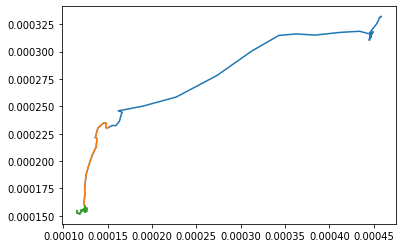

In [21]:
import matplotlib.pyplot as plt
x, y = evoked_eye[event_id].get_data()
times = evoked_eye[event_id].times
plt.plot(x, y)
plt.plot(x[times > 0.3], y[times > 0.3])
plt.plot(x[times > 0.5], y[times > 0.5])